# Tracking the Growth of COVID-19 Cases in Japan

### データソース  
以下のダッシュボードのgithubで公開されているcsvを使用してます。

* 新型コロナウイルス感染速報  
https://covid-2019.live/

* csv  
https://raw.githubusercontent.com/swsoyee/2019-ncov-japan/master/Data/byDate.csv

In [1]:
# Now
! date

2020年  4月  7日 火曜日 23:09:34 JST


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

from matplotlib.dates import DateFormatter
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook  # If you switch from inline to notebook, you must restart the kernel!

#matplotlibで日本語フォントを使う設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


# データ・セット

In [3]:
# csv読み込み
df_raw = pd.read_csv( 'https://raw.githubusercontent.com/swsoyee/2019-ncov-japan/master/Data/byDate.csv')

# 全部 Nanの行は削除
if( df_raw.iloc[-1:,1:].isnull().all(axis=1).values[0] == True ):
    df_raw = df_raw.drop(df_raw.index.values[-1])
    print('drop [.isnull().all()] record')

# 日付に変換
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y%m%d')
days = df_raw['date'].dt.strftime('%m/%d/%y').values.tolist()

# 欠損値を0にする
df_raw = df_raw.fillna(0)

# 増加数と日本全体(クルーズ船とチャーター便を除く)
inc = df_raw
inc['日本全体'] = inc.drop(columns=['クルーズ船','チャーター便']).iloc[:,1:].sum(axis=1)

# 累積数を出す
tot = pd.concat( [inc.iloc[:,0:1], inc.iloc[:,1:].cumsum()], axis=1)

# 流用元(global版)と同じ構成になるよう
tmp = tot.set_index('date').T.reset_index()
tmp.columns.name = None
tmp = tmp.rename(columns={'index':'Country/Region'})
tmp['Province/State'] = np.nan
tmp['Lat'] = np.nan
tmp['Long'] = np.nan
df = pd.concat([tmp[['Province/State', 'Country/Region', 'Lat', 'Long']], tmp.iloc[:, 1:-3]], axis=1)
df.columns = df.columns[0:4].values.tolist() + days

In [4]:
 df.head()

,Province/State,Country/Region,Lat,Long,01/15/20,01/16/20,01/17/20,01/18/20,01/19/20,01/20/20,...,03/29/20,03/30/20,03/31/20,04/01/20,04/02/20,04/03/20,04/04/20,04/05/20,04/06/20,04/07/20
0,NaN,北海道,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,175.0,176.0,176.0,180.0,183.0,188.0,191.0,191.0,191.0,195.0
1,NaN,青森,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,8.0,8.0,8.0,9.0,11.0,11.0,11.0,11.0,12.0
2,NaN,岩手,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,宮城,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,6.0,7.0,11.0,12.0,18.0,20.0,23.0,26.0,32.0
4,NaN,秋田,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,6.0,7.0,9.0,10.0,11.0,11.0,11.0,11.0


In [5]:
df.head()

,Province/State,Country/Region,Lat,Long,01/15/20,01/16/20,01/17/20,01/18/20,01/19/20,01/20/20,...,03/29/20,03/30/20,03/31/20,04/01/20,04/02/20,04/03/20,04/04/20,04/05/20,04/06/20,04/07/20
0,NaN,北海道,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,175.0,176.0,176.0,180.0,183.0,188.0,191.0,191.0,191.0,195.0
1,NaN,青森,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,8.0,8.0,8.0,9.0,11.0,11.0,11.0,11.0,12.0
2,NaN,岩手,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,宮城,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,6.0,7.0,11.0,12.0,18.0,20.0,23.0,26.0,32.0
4,NaN,秋田,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,6.0,7.0,9.0,10.0,11.0,11.0,11.0,11.0


## COVID-19 Analysis

In [6]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
#cases = cases[cases[mostrecentdate] >= 100]
cases = cases[cases[mostrecentdate] >= 20]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 04/07/20


,04/07/20
Country/Region,
日本全体,4433.0
東京,1195.0
クルーズ船,712.0
大阪,481.0
千葉,292.0


## Curve Fitting Global COVID-19 Cases

In [7]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



日本全体

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 4433.0
	Confirmed cases on 03/31/20 	 2216.0
	Ratio: 2.0
	Weekly increase: 100.0 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9920497547249507
	Doubling Time (during middle of growth):  16.21 (± 0.67 ) days
	param:  [7.49383520e+10 8.55206820e-02 2.65306501e+01 2.66597913e+11]

** Based on Exponential Fit **

	R^2: 0.9920497549046464
	Doubling Time (represents overall growth):  8.11 (± 0.34 ) days
	param:  [ 3.55759908  0.08552055 26.53001902]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



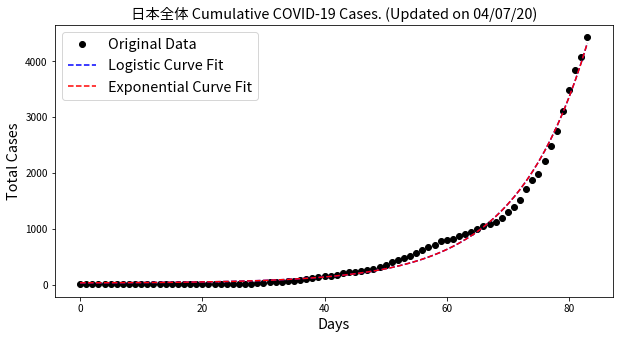



東京

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 1195.0
	Confirmed cases on 03/31/20 	 521.0
	Ratio: 2.29
	Weekly increase: 129.4 %
	Daily increase: 12.6 % per day
	Doubling Time (represents recent growth): 5.8 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9950757626739052
	Doubling Time (represents overall growth):  5.37 (± 0.18 ) days
	param:  [ 0.08790643  0.12916513 14.55325195]


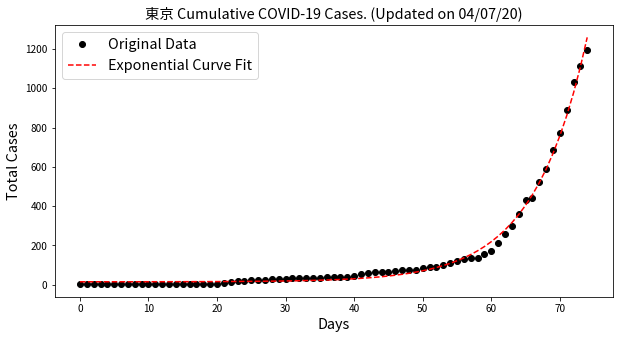



クルーズ船

** Based on Logistic Fit**

	R^2: 0.9950585577797704
	Doubling Time (during middle of growth):  3.21 (± 0.29 ) days
	param:  [1.05089156e+02 4.31524529e-01 3.91449107e+01 7.07420592e+02]

 exponential R^2  -0.14809683671448726


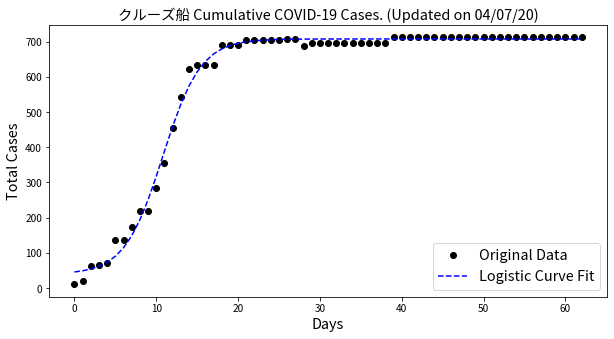



大阪

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 481.0
	Confirmed cases on 03/31/20 	 244.0
	Ratio: 1.97
	Weekly increase: 97.1 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.984206311966041
	Doubling Time (during middle of growth):  18.07 (± 1.53 ) days
	param:  [ 6.47167553e+09  7.67140601e-02 -5.74561070e+00  1.52206389e+10]

** Based on Exponential Fit **

	R^2: 0.9842063122131951
	Doubling Time (represents overall growth):  9.04 (± 0.64 ) days
	param:  [ 2.3518902   0.07671403 -5.74563744]


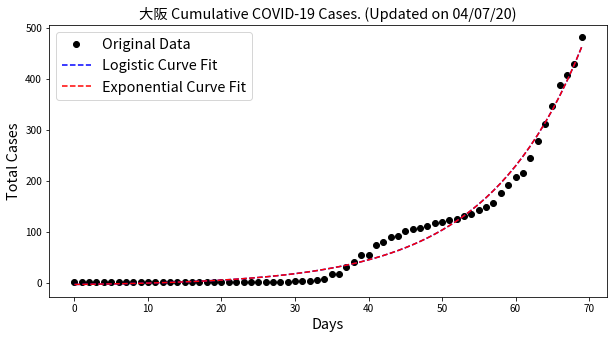



千葉

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 292.0
	Confirmed cases on 03/31/20 	 172.0
	Ratio: 1.7
	Weekly increase: 69.8 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9820264807132931
	Doubling Time (during middle of growth):  7.29 (± 1.27 ) days
	param:  [1.58580507e+05 1.90208846e-01 8.82173549e+00 4.27536099e+02]

** Based on Exponential Fit **

	R^2: 0.9765725254018026
	Doubling Time (represents overall growth):  6.33 (± 0.51 ) days
	param:  [0.20475274 0.10944152 3.79637572]


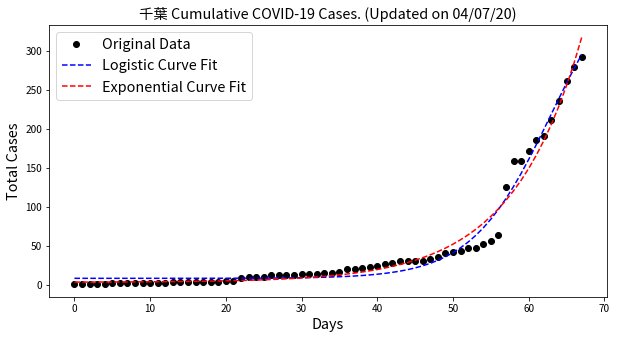



神奈川

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 289.0
	Confirmed cases on 03/31/20 	 142.0
	Ratio: 2.04
	Weekly increase: 103.5 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9843101692266839
	Doubling Time (during middle of growth):  16.71 (± 1.06 ) days
	param:  [6.09181100e+10 8.29506437e-02 4.10414404e+00 1.75661978e+10]

** Based on Exponential Fit **

	R^2: 0.9843101694640234
	Doubling Time (represents overall growth):  8.36 (± 0.5 ) days
	param:  [0.28836064 0.08295051 4.1040969 ]


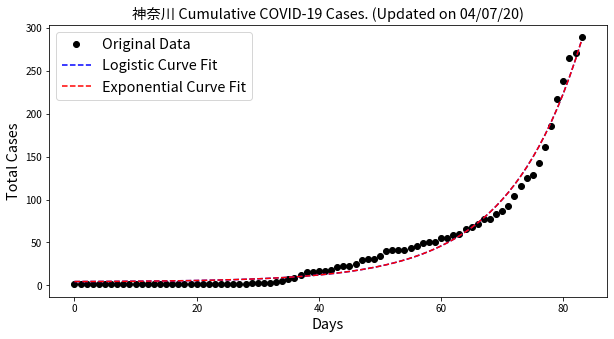



愛知

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 250.0
	Confirmed cases on 03/31/20 	 178.0
	Ratio: 1.4
	Weekly increase: 40.4 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.3 days

** Based on Logistic Fit**

	R^2: 0.9817668078957182
	Doubling Time (during middle of growth):  16.63 (± 3.14 ) days
	param:  [ 7.96042761e+01  8.33519156e-02 -8.88235681e+00  2.63903736e+02]

** Based on Exponential Fit **

	R^2: 0.972084867411041
	Doubling Time (represents overall growth):  23.84 (± 3.82 ) days
	param:  [ 3.65427521e+01  2.90707541e-02 -5.16919700e+01]


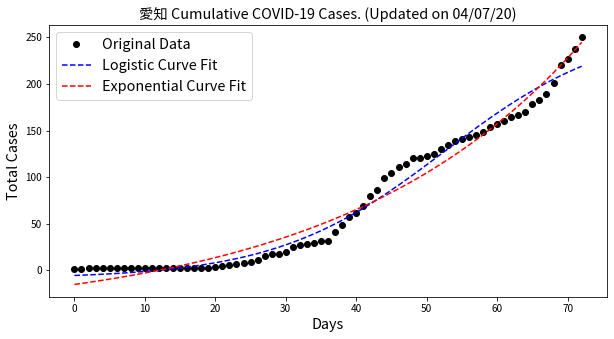



兵庫

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 229.0
	Confirmed cases on 03/31/20 	 148.0
	Ratio: 1.55
	Weekly increase: 54.7 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9774701476422073
	Doubling Time (during middle of growth):  114.23 (± nan ) days
	param:  [ 1.11547634e+05  1.21357426e-02 -3.94258594e+02  4.29871102e+07]

** Based on Exponential Fit **

	R^2: 0.9698123393329967
	Doubling Time (represents overall growth):  22.2 (± 8.83 ) days
	param:  [ 1.00000000e+02  3.12254168e-02 -9.64245809e+01]


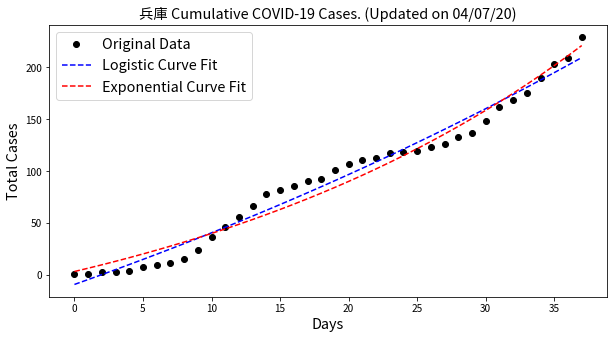



埼玉

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 216.0
	Confirmed cases on 03/31/20 	 100.0
	Ratio: 2.16
	Weekly increase: 116.0 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9901664336544894
	Doubling Time (during middle of growth):  14.52 (± 0.99 ) days
	param:  [ 2.73964226e+09  9.55038181e-02 -1.98773766e+00  7.21412776e+09]

** Based on Exponential Fit **

	R^2: 0.9901664339349686
	Doubling Time (represents overall growth):  7.26 (± 0.53 ) days
	param:  [ 2.63326076  0.09550362 -1.98781947]


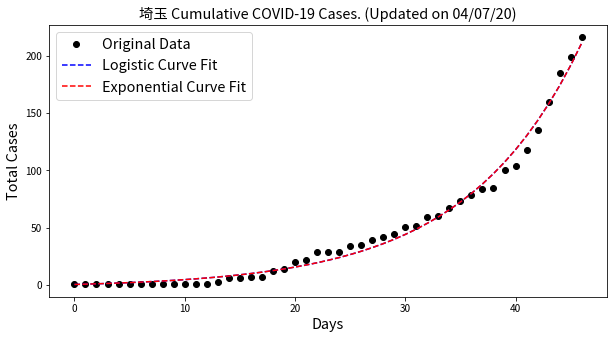



福岡

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 199.0
	Confirmed cases on 03/31/20 	 46.0
	Ratio: 4.33
	Weekly increase: 332.6 %
	Daily increase: 23.3 % per day
	Doubling Time (represents recent growth): 3.3 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9752823119322249
	Doubling Time (represents overall growth):  3.59 (± 0.35 ) days
	param:  [0.02492333 0.19326463 0.03994974]


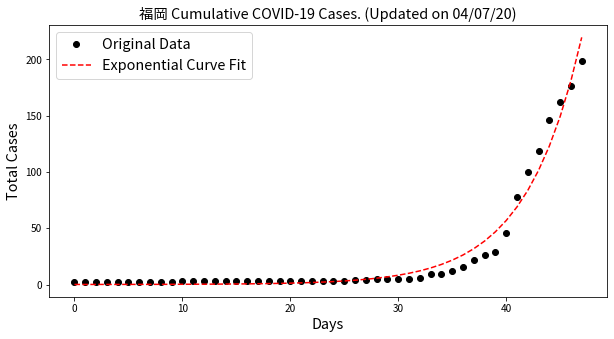



北海道

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 195.0
	Confirmed cases on 03/31/20 	 176.0
	Ratio: 1.11
	Weekly increase: 10.8 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 47.3 days

** Based on Logistic Fit**

	R^2: 0.9928341806504207
	Doubling Time (during middle of growth):  10.41 (± 0.97 ) days
	param:  [ 1.49609149e+02  1.33194445e-01 -5.89166598e+00  1.85788860e+02]

 exponential R^2  0.9358882331107796


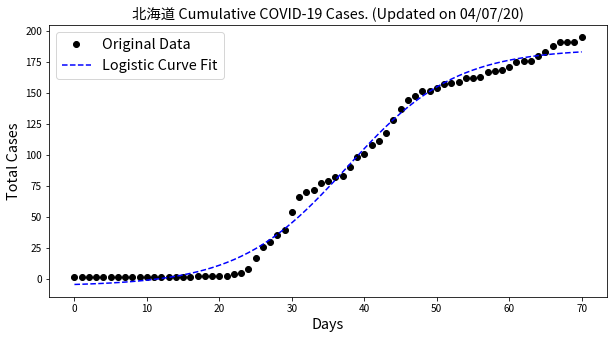



京都

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 145.0
	Confirmed cases on 03/31/20 	 69.0
	Ratio: 2.1
	Weekly increase: 110.1 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.5 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.988880738595504
	Doubling Time (represents overall growth):  5.92 (± 0.32 ) days
	param:  [0.05197118 0.11711106 2.22810905]


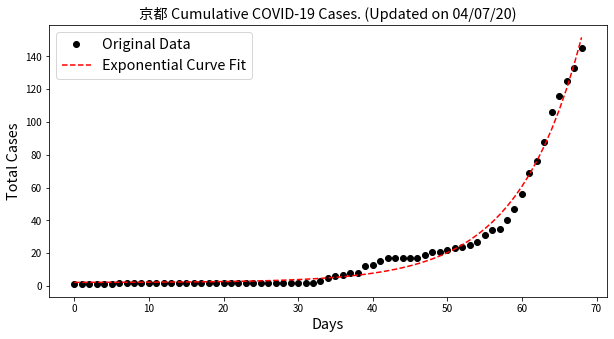



検疫職員

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 84.0
	Confirmed cases on 03/31/20 	 66.0
	Ratio: 1.27
	Weekly increase: 27.3 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.1 days

** Based on Logistic Fit**

	R^2: 0.9834730287277019
	Doubling Time (during middle of growth):  8.88 (± 1.68 ) days
	param:  [2.05124241e+03 1.56084369e-01 5.69006438e+00 1.19932678e+02]

** Based on Exponential Fit **

	R^2: 0.9760267143317085
	Doubling Time (represents overall growth):  8.75 (± 0.92 ) days
	param:  [1.18798867 0.07924365 1.69746976]


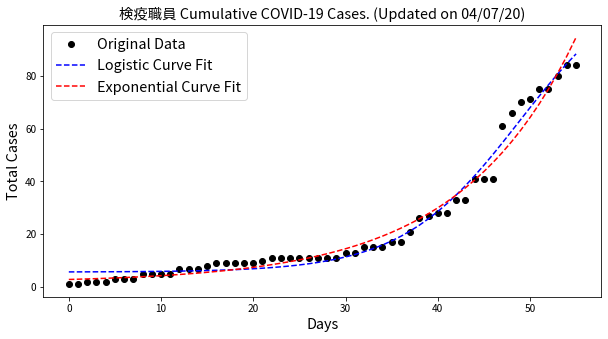



茨城

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 77.0
	Confirmed cases on 03/31/20 	 24.0
	Ratio: 3.21
	Weekly increase: 220.8 %
	Daily increase: 18.1 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9906651394082627
	Doubling Time (during middle of growth):  3.96 (± 0.93 ) days
	param:  [313.2628797    0.35050002   2.93006766  91.01345429]

** Based on Exponential Fit **

	R^2: 0.9772083171510894
	Doubling Time (represents overall growth):  5.47 (± 1.24 ) days
	param:  [ 6.25014906  0.12680435 -7.01011984]


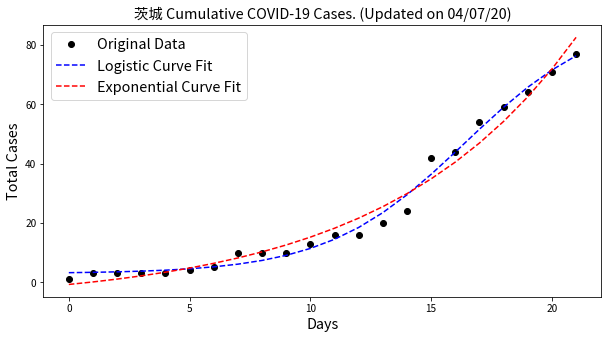



岐阜

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 69.0
	Confirmed cases on 03/31/20 	 26.0
	Ratio: 2.65
	Weekly increase: 165.4 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.994516815713412
	Doubling Time (during middle of growth):  7.38 (± 1.07 ) days
	param:  [3.15925912e+03 1.87883572e-01 1.26510137e+00 1.64233742e+02]

** Based on Exponential Fit **

	R^2: 0.992445477218973
	Doubling Time (represents overall growth):  4.84 (± 0.3 ) days
	param:  [0.19802242 0.1432807  0.50966046]


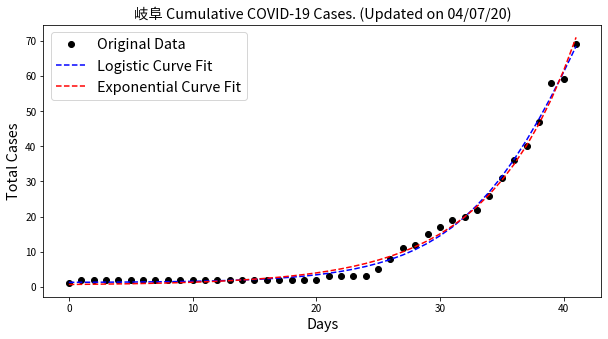



福井

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 65.0
	Confirmed cases on 03/31/20 	 20.0
	Ratio: 3.25
	Weekly increase: 225.0 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9936643781626969
	Doubling Time (during middle of growth):  4.41 (± 0.99 ) days
	param:  [2.11633692e+02 3.14678753e-01 1.02366295e-01 9.10783748e+01]

** Based on Exponential Fit **

	R^2: 0.9853156043002225
	Doubling Time (represents overall growth):  4.68 (± 0.81 ) days
	param:  [ 3.88710217  0.14804953 -5.72802241]


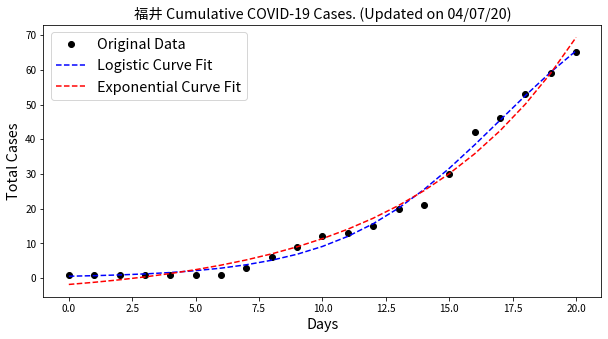



石川

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 55.0
	Confirmed cases on 03/31/20 	 13.0
	Ratio: 4.23
	Weekly increase: 323.1 %
	Daily increase: 22.9 % per day
	Doubling Time (represents recent growth): 3.4 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9712701869523069
	Doubling Time (represents overall growth):  2.69 (± 0.28 ) days
	param:  [3.75390885e-04 2.57253503e-01 5.67924377e+00]


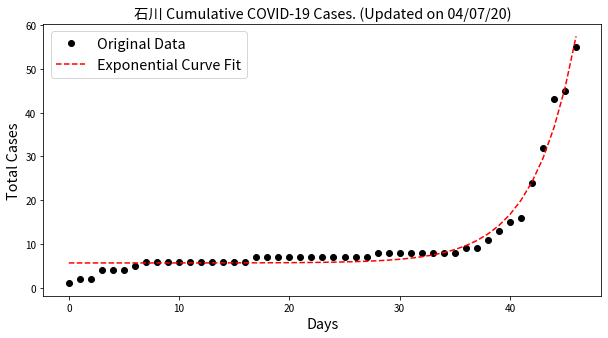



高知

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 38.0
	Confirmed cases on 03/31/20 	 17.0
	Ratio: 2.24
	Weekly increase: 123.5 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

 logistic R^2  0.8805183535190044

 exponential R^2  0.8805183570080085


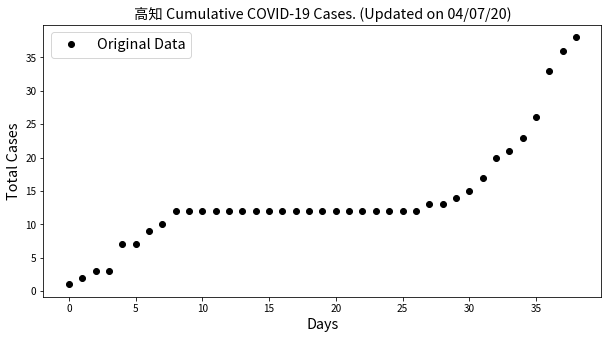



新潟

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 37.0
	Confirmed cases on 03/31/20 	 31.0
	Ratio: 1.19
	Weekly increase: 19.4 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.4 days

** Based on Logistic Fit**

	R^2: 0.9906737516437999
	Doubling Time (during middle of growth):  9.21 (± 1.73 ) days
	param:  [ 9.15222895  0.15055924 -1.95583019 35.76565382]

** Based on Exponential Fit **

	R^2: 0.9545162748815079
	Doubling Time (represents overall growth):  82.97 (± 142.06 ) days
	param:  [ 1.00000000e+02  8.35411655e-03 -9.71052845e+01]


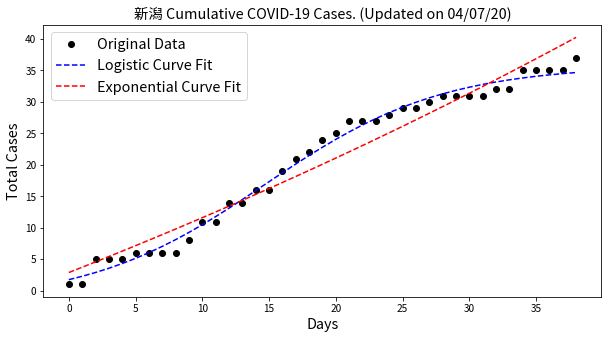



大分

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 35.0
	Confirmed cases on 03/31/20 	 29.0
	Ratio: 1.21
	Weekly increase: 20.7 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 25.8 days

** Based on Logistic Fit**

	R^2: 0.9832745286877826
	Doubling Time (during middle of growth):  2.32 (± 0.55 ) days
	param:  [6.94170364e+04 5.96594532e-01 5.60584145e-01 3.01081933e+01]

 exponential R^2  0.8885222252611951


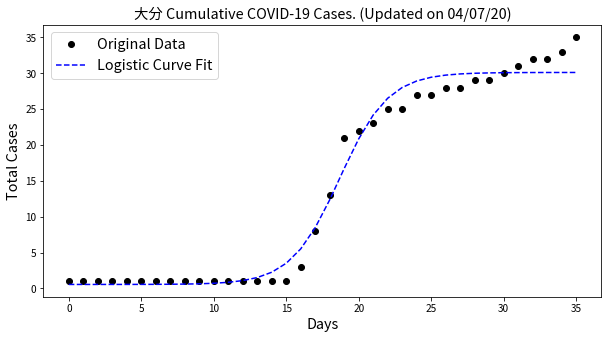



沖縄

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 34.0
	Confirmed cases on 03/31/20 	 9.0
	Ratio: 3.78
	Weekly increase: 277.8 %
	Daily increase: 20.9 % per day
	Doubling Time (represents recent growth): 3.7 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

 exponential R^2  0.9498455142797124


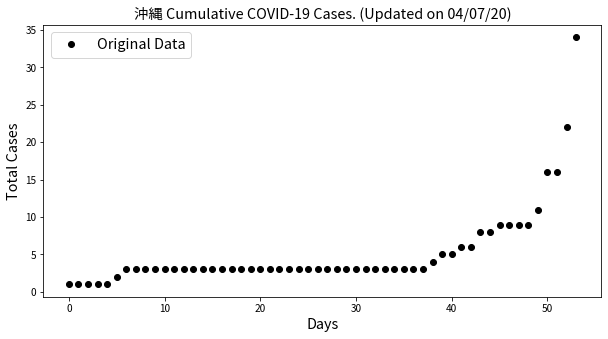



宮城

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 32.0
	Confirmed cases on 03/31/20 	 7.0
	Ratio: 4.57
	Weekly increase: 357.1 %
	Daily increase: 24.2 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.9947669704245102
	Doubling Time (during middle of growth):  3.52 (± 0.43 ) days
	param:  [9.97301389e+05 3.93516809e-01 8.86573850e-01 4.01037331e+01]

** Based on Exponential Fit **

	R^2: 0.982198101631806
	Doubling Time (represents overall growth):  3.24 (± 0.3 ) days
	param:  [0.00984241 0.2136246  0.49867172]


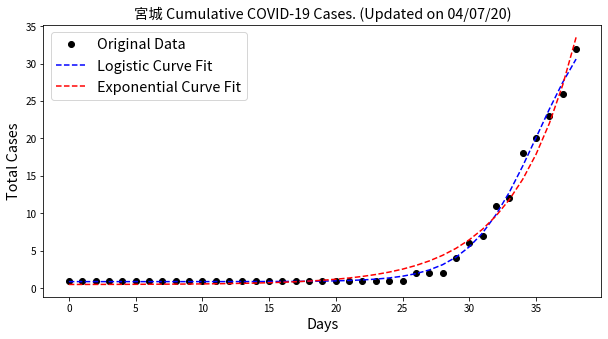



和歌山

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 31.0
	Confirmed cases on 03/31/20 	 18.0
	Ratio: 1.72
	Weekly increase: 72.2 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

 logistic R^2  0.7628939372278232

 exponential R^2  0.7628939424183472


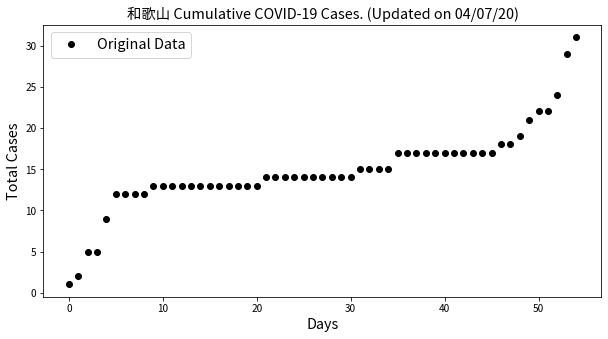



群馬

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 29.0
	Confirmed cases on 03/31/20 	 19.0
	Ratio: 1.53
	Weekly increase: 52.6 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.5 days

** Based on Logistic Fit**

	R^2: 0.9814433034969575
	Doubling Time (during middle of growth):  61.29 (± 571.36 ) days
	param:  [ 4.28687318e+05  2.26190352e-02 -2.75462543e+01  1.18491895e+07]

** Based on Exponential Fit **

	R^2: 0.9814433061958773
	Doubling Time (represents overall growth):  30.64 (± 16.65 ) days
	param:  [ 2.76405895e+01  2.26190001e-02 -2.75461926e+01]


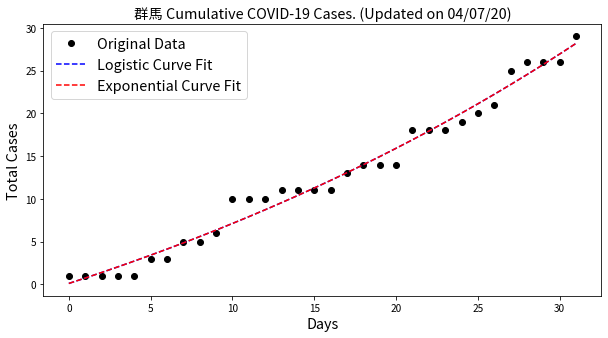



奈良

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 28.0
	Confirmed cases on 03/31/20 	 11.0
	Ratio: 2.55
	Weekly increase: 154.5 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

 logistic R^2  0.9367926327466046

 exponential R^2  0.9367926350815364


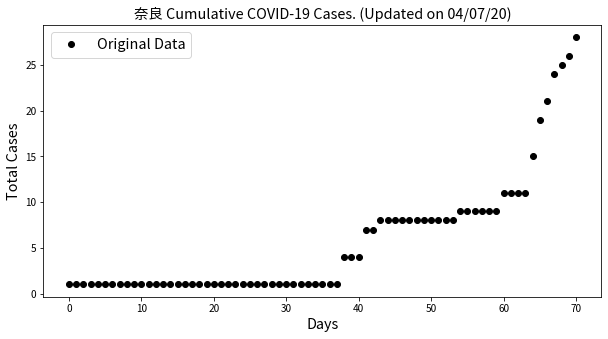



福島

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 24.0
	Confirmed cases on 03/31/20 	 4.0
	Ratio: 6.0
	Weekly increase: 500.0 %
	Daily increase: 29.2 % per day
	Doubling Time (represents recent growth): 2.7 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9718283371560266
	Doubling Time (represents overall growth):  2.61 (± 0.34 ) days
	param:  [0.0059992  0.26539793 1.30365585]


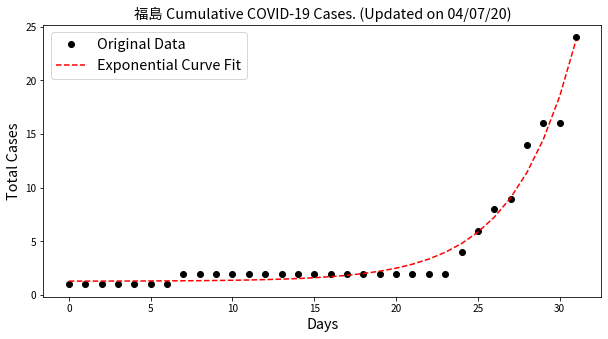



滋賀

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 24.0
	Confirmed cases on 03/31/20 	 7.0
	Ratio: 3.43
	Weekly increase: 242.9 %
	Daily increase: 19.2 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.950870455035819
	Doubling Time (during middle of growth):  8.33 (± 2.94 ) days
	param:  [3.02330990e+09 1.66382880e-01 1.68317586e+00 2.70051149e+08]

** Based on Exponential Fit **

	R^2: 0.950870456096625
	Doubling Time (represents overall growth):  4.17 (± 0.76 ) days
	param:  [0.08932492 0.16638221 1.68316368]


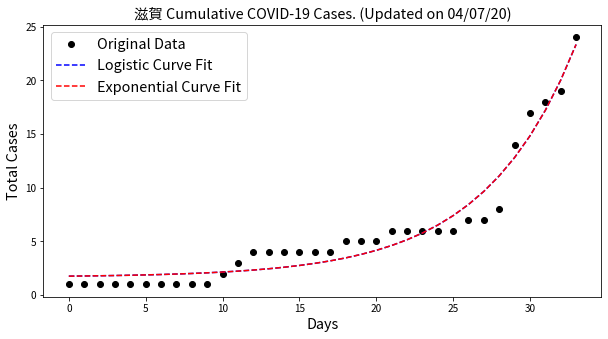



愛媛

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 23.0
	Confirmed cases on 03/31/20 	 9.0
	Ratio: 2.56
	Weekly increase: 155.6 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9850869062402943
	Doubling Time (during middle of growth):  2.14 (± 0.44 ) days
	param:  [5.11924145e+08 6.49143486e-01 2.31695255e+00 2.41478254e+01]

 exponential R^2  0.94383607267695


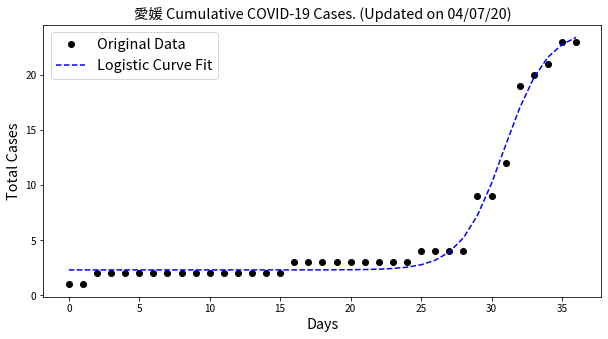



静岡

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 22.0
	Confirmed cases on 03/31/20 	 11.0
	Ratio: 2.0
	Weekly increase: 100.0 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9722828548864677
	Doubling Time (during middle of growth):  2.93 (± 0.77 ) days
	param:  [5.62937232e+06 4.73795042e-01 1.97464464e+00 2.10045067e+01]

** Based on Exponential Fit **

	R^2: 0.9502224299728429
	Doubling Time (represents overall growth):  4.79 (± 0.8 ) days
	param:  [0.077919   0.14482206 1.11293065]


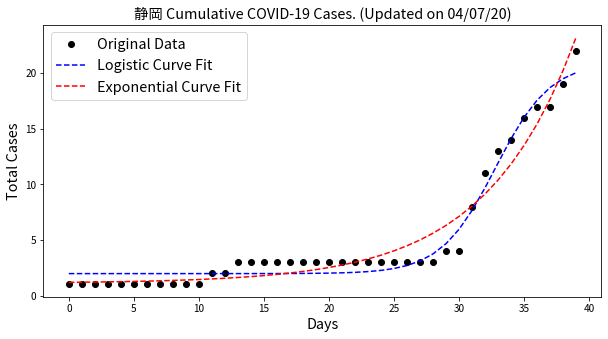



山梨

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 22.0
	Confirmed cases on 03/31/20 	 6.0
	Ratio: 3.67
	Weekly increase: 266.7 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9882871773581738
	Doubling Time (during middle of growth):  6.61 (± 1.19 ) days
	param:  [8.52827364e+09 2.09571693e-01 1.79140036e+00 2.11016542e+08]

** Based on Exponential Fit **

	R^2: 0.9882871775017076
	Doubling Time (represents overall growth):  3.31 (± 0.28 ) days
	param:  [0.0247432  0.20957167 1.79140012]


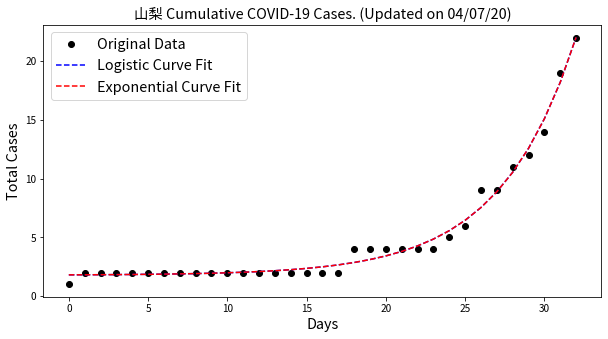



熊本

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 21.0
	Confirmed cases on 03/31/20 	 14.0
	Ratio: 1.5
	Weekly increase: 50.0 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 12.0 days

** Based on Logistic Fit**

	R^2: 0.9609051197855696
	Doubling Time (during middle of growth):  7.48 (± 2.45 ) days
	param:  [2.22622944e+03 1.85303487e-01 4.89253956e+00 2.79415451e+01]

** Based on Exponential Fit **

	R^2: 0.9571117314900105
	Doubling Time (represents overall growth):  7.15 (± 1.11 ) days
	param:  [0.20473548 0.09698052 4.15358433]


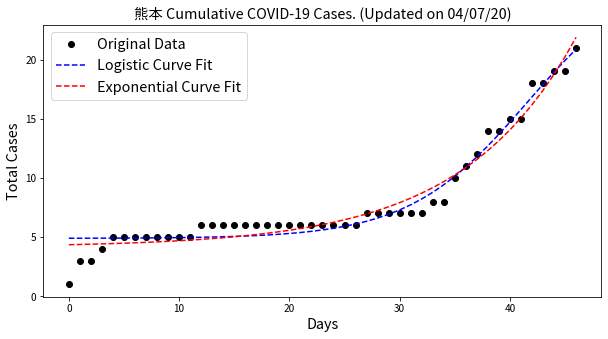



栃木

** Based on Most Recent Week of Data **

	Confirmed cases on 04/07/20 	 20.0
	Confirmed cases on 03/31/20 	 14.0
	Ratio: 1.43
	Weekly increase: 42.9 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.6 days

** Based on Logistic Fit**

	R^2: 0.9825871967143931
	Doubling Time (during middle of growth):  5.13 (± 0.96 ) days
	param:  [9.84235507e+03 2.70306875e-01 1.30461466e+00 1.92486385e+01]

 exponential R^2  0.9472180970266717


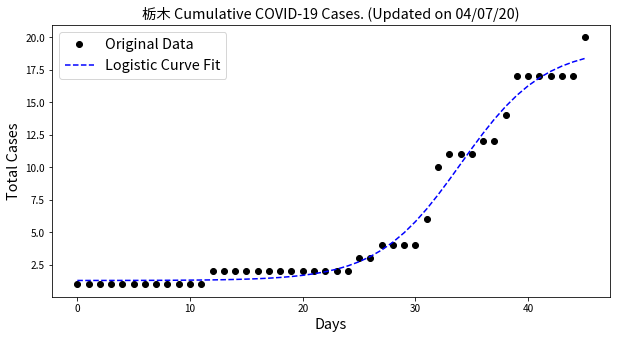

In [8]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


    Inferred Doubling Time  95%CI  Recent Doubling Time
0                      8.1    0.3                   7.0
1                      5.4    0.2                   5.8
2                      3.2    0.3                   NaN
3                      9.0    0.6                   7.1
4                      6.3    0.5                   9.2
5                      8.4    0.5                   6.8
6                     16.6    3.1                  14.3
7                    114.2    NaN                  11.1
8                      7.3    0.5                   6.3
9                      3.6    0.3                   3.3
10                    10.4    1.0                  47.3
11                     5.9    0.3                   6.5
12                     8.7    0.9                  20.1
13      

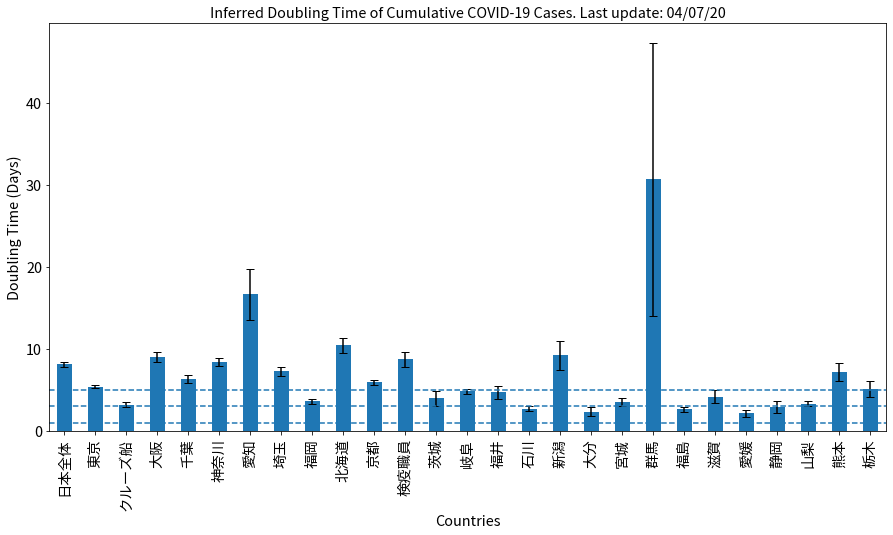

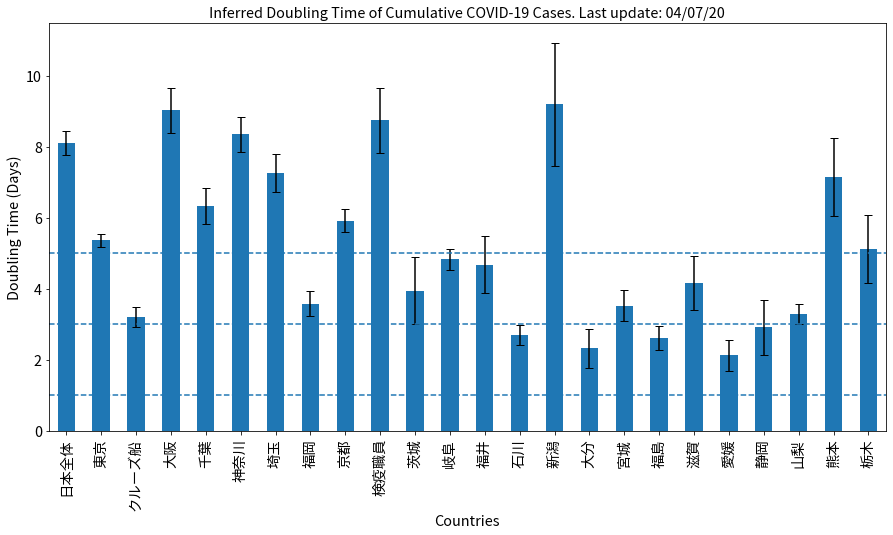

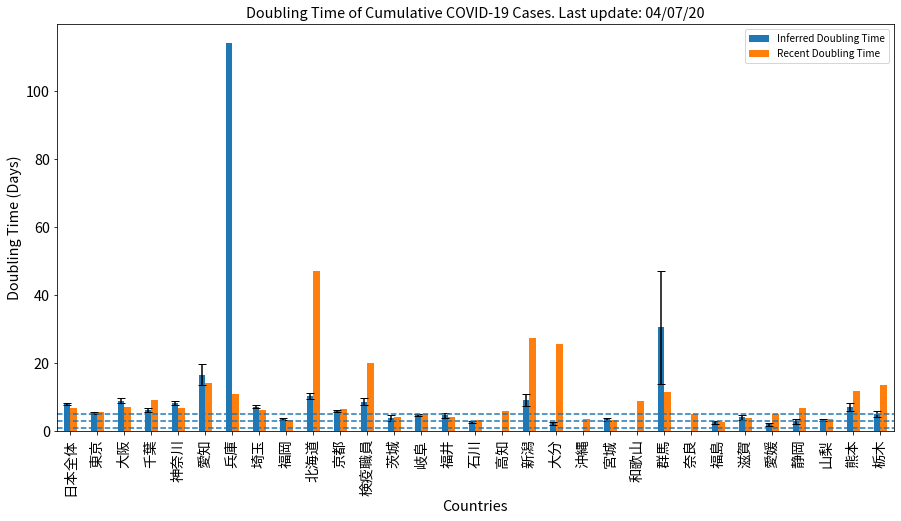

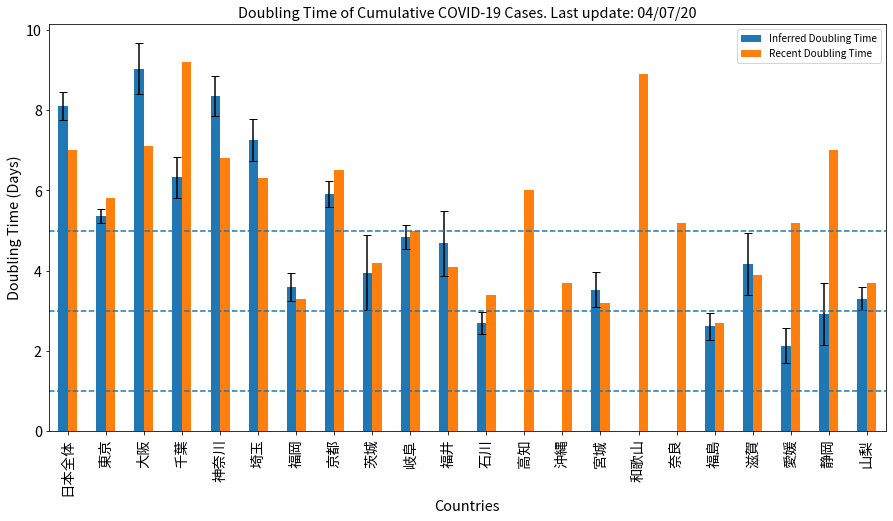

In [9]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()